In [2]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
sns.set(style="whitegrid")

Parameters:

In [4]:
alpha = 0.9
beta = 0.2
lambda_p = [1,5]
gamma = 0.1

Big gamma matrix:

In [5]:
big_gamma = np.array([[1- gamma, 0, gamma], [0, 1-gamma, gamma], [beta/2, beta/2, 1- beta]])
big_gamma

array([[0.9, 0. , 0.1],
       [0. , 0.9, 0.1],
       [0.1, 0.1, 0.8]])

Simulation function

In [6]:
def sim(n,T):
    C = [None]*T
    C[0] = 2
    C_trans = {(1,0,0): 0, (0,1,0): 1, (0,0,1): 2} 

    for i in range(1,T):
        draw = np.random.multinomial(1, big_gamma[C[i-1], :], 1)
        C[i] = C_trans[tuple(draw[0])]

    Z = np.empty([n, T])

    probs = {0: 1-alpha, 1: alpha, 2: 0.5}

    for i in range(n):
        for j in range(T):
            Z[i,j] = np.random.binomial(1, probs[C[j]])

    X = np.empty([n, T])

    for i in range(n):
        for j in range(T):
            X[i,j] = poisson.rvs(lambda_p[int(Z[i,j])])

    return C,Z,X

In [7]:
C, Z, X = sim(10,100)

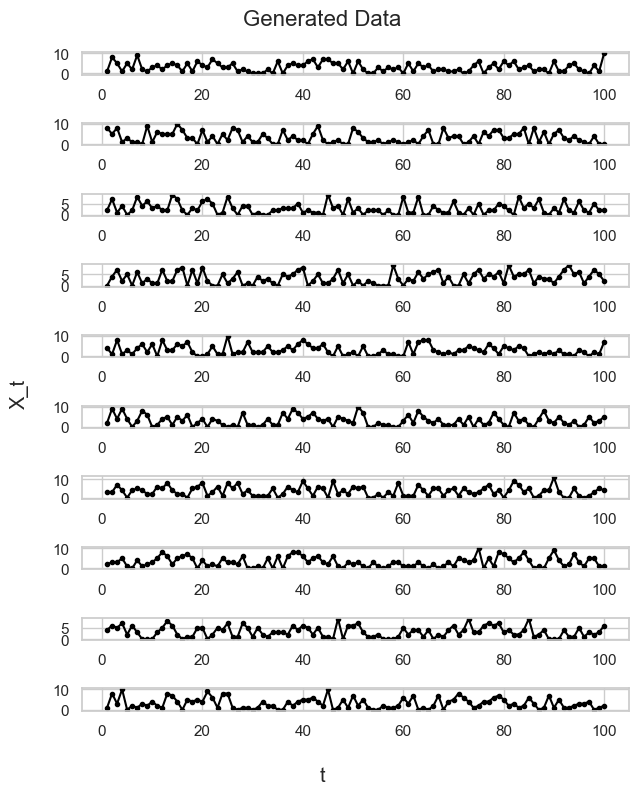

In [8]:
fig, axs = plt.subplots(10, 1, figsize= (6.5, 8))
x_plot = list(range(1,100+1))

for i in range(10):
    y_plot = X[i]
    axs[i].plot(x_plot, y_plot, marker='o', markersize=3, color='black')
    #axs[i].text(1.05, 0.5, f'{i + 1}', fontsize=12, rotation=270)

fig.suptitle('Generated Data', fontsize=16)
fig.supxlabel('t')
fig.supylabel('X_t')

plt.tight_layout()
plt.show()


In [14]:
X_avg = [None]*100

for i in range(100):
    X_avg[i] = np.mean(X[:,i])



Text(0.5, 1.0, 'Average')

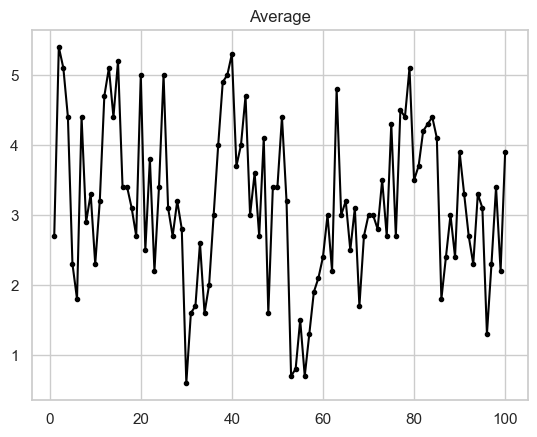

In [18]:
plt.plot(x_plot, X_avg, marker='o', markersize=3, color='black')
plt.title('Average')